In [1]:
import os
from PIL import Image

import time
import numpy as np
import tensorflow as tf
import pandas as pd


from user import User
from average import Average
from tensorflow import keras

from graphing import *
from file_related import *
from inits import *
from trainers import *
SEED = 0

# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:

# https://www.kaggle.com/prasunroy/natural-images
data_dir = "../testing/data/natural_images/"

CLASSES, files = map_images(data_dir)
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]


In [3]:
def train(model, toy=False):
        """
        Train the model
        """
        if toy:
            epochs=3
            steps_per_epoch=20
            validation_steps=2
        else:
            epochs=30
#             steps_per_epoch=100
            steps_per_epoch=30
#             steps_per_epoch=10
            validation_steps=5
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_acc'
                                        ,verbose=1
                                        ,save_best_only=True
                                        ,save_weights_only=True)
        # Train
        training = model.fit(x_train, y_train
                                ,epochs=epochs
                                ,steps_per_epoch=steps_per_epoch
                                ,validation_data=(x_val, y_val)
                                ,validation_steps=validation_steps
                                ,callbacks=[earlystopper, checkpointer, reduce_lr], verbose=3)
        # Get the best saved weights
        model.load_weights('best_model1.h5')
        return training

In [4]:
ROUNDS = 32 # after about 30-40, it seems to settle down with epochs being 16
EPOCHS = 16
MAJORITY_SPLIT = 0.5

In [5]:
# forces tensorfor to the a particular device to run things
#      # return a dictionary of users with data
users_all = init_users_image(files, averaging_methods, majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_all, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.all,
          averaging_post = True,
          averaging_metric = "accuracy")

    # return a dictionary of users with data
#     users_all_p2p, global_user = init_users(df = df, 
#                                         averaging_methods = averaging_methods, 
#                                        majority_split = MAJORITY_SPLIT, seed = SEED)
#     train_fed(users = users_all_p2p, rounds = ROUNDS,
#               epochs = EPOCHS,
              
#               strat = "personalised",
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_post = True,
#               averaging_metric = "accuracy")
    
#      print(len(users_all[2].get_history_metrics()["sparse_categorical_accuracy"]))
#     draw_graphs(users_all[2])   

********************************  0   ********************************
0 [10.052072646125914, 0.04761905]
1 [8.326821461196774, 0.09090909]
2 [15.554481802060623, 0.08527132]
3 [11.466238613546329, 0.0729927]
4 [7.263989130655925, 0.20833333]
5 [5.534630871505189, 0.352518]
6 [12.8744749262713, 0.07971015]
7 [9.127996126810709, 0.11363637]
******************************** DONE ********************************
********************************  1   ********************************
0 [2.100365780648731, 0.1904762]
1 [2.0476627152813367, 0.1983471]
2 [2.0835719644561292, 0.15503876]
3 [2.0594266331108817, 0.16788322]
4 [2.0272263288497925, 0.30833334]
5 [1.960161193669271, 0.52517986]
6 [1.9807112562483635, 0.5942029]
7 [2.027680238087972, 0.25757575]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.8698553755169823, 0.73015875]
1 [0.9340089313254869, 0.6942149]
2 [1.2221594771673514, 0.573643

All
For central
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.898441
Standard Deviation    0.0576892
Minimum                0.758333
Maximum                0.942029
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.921999
Standard Deviation    0.0169943
Minimum                0.886364
Maximum                0.942029
Name: 63, dtype: object



/home/kts1/proj/src/graphing.py:312: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(f'{save_as}.csv')
/home/kts1/proj/src/graphing.py:329: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(f'{save_as}.csv')


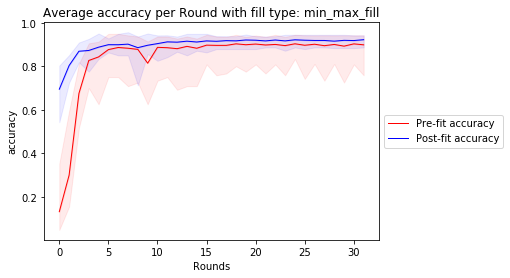

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.928571
3     1     0.925620
5     2     0.906977
7     3     0.934307
9     4     0.758333
11    5     0.928058
13    6     0.942029
15    7     0.863636
Averaged: 0.8984413519501686

Final accuracy for Post-fit data
   User  Final Value
0     0     0.936508
2     1     0.917355
4     2     0.930233
6     3     0.934307
8     4     0.908333
10    5     0.920863
12    6     0.942029
14    7     0.886364
Averaged: 0.9219989702105522



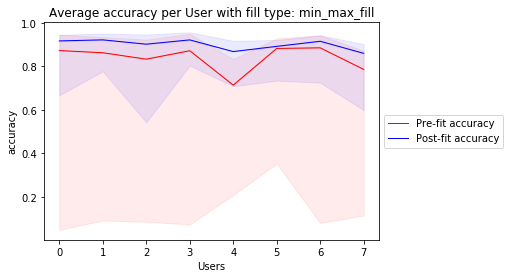

<Figure size 432x288 with 0 Axes>

In [6]:
ignore_first_n = 0
final_values = True

GRAPHING_METRIC = "accuracy"


print("All")

# print("For p2p")


# df_avg_round_stats_acc = avg_round_stats(users_all_p2p, 
#                                          ignore_first_n = ignore_first_n, 
#                                          min_max_fill = True, 
#                                          metric = "accuracy",
#                                          final_values = final_values)
# df_avg_user_stats_acc = avg_user_stats(users_all_p2p, 
#                                        ignore_first_n = ignore_first_n, 
#                                        min_max_fill = True, 
#                                        metric = "accuracy",
#                                        final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-centralround-{MAJORITY_SPLIT}.png",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-centraluser-{MAJORITY_SPLIT}.png",
                                       final_values = final_values)

In [7]:
averaging_methods = [Average.std_dev]
# return a dictionary of users with data
users_std_dev = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_std_dev, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method =  Average.std_dev,
         averaging_post = True,
          averaging_metric = "accuracy")

# return a dictionary of users with data
users_std_dev_p2p = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_std_dev_p2p, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "personalised",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")



********************************  0   ********************************
0 [10.052072646125914, 0.04761905]
1 [8.326821461196774, 0.09090909]
2 [15.554481802060623, 0.08527132]
3 [11.466238613546329, 0.0729927]
4 [7.263989130655925, 0.20833333]
5 [5.534630871505189, 0.352518]
6 [12.8744749262713, 0.07971015]
7 [9.127996126810709, 0.11363637]
User 0: 0.6428571343421936 < 0.6618549094890778
User 4: 0.625 < 0.6618549094890778
******************************** DONE ********************************
********************************  1   ********************************
0 [2.090737916174389, 0.11904762]
1 [2.047898072841739, 0.12396694]
2 [2.088988740314809, 0.10852713]
3 [2.0627985557500463, 0.11678832]
4 [2.03315802415212, 0.13333334]
5 [1.9706583477610307, 0.20143884]
6 [1.918955215509387, 0.557971]
7 [2.0295550136855156, 0.11363637]
User 4: 0.75 < 0.7553566228539146
User 7: 0.6969696879386902 < 0.7553566228539146
******************************** DONE ********************************
********

Std deviation
For central
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.907721
Standard Deviation    0.0409031
Minimum                0.833333
Maximum                0.949275
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                 0.92219
Standard Deviation    0.0373005
Minimum                0.833333
Maximum                0.956204
Name: 63, dtype: object



/home/kts1/proj/src/graphing.py:312: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(f'{save_as}.csv')
/home/kts1/proj/src/graphing.py:329: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(f'{save_as}.csv')


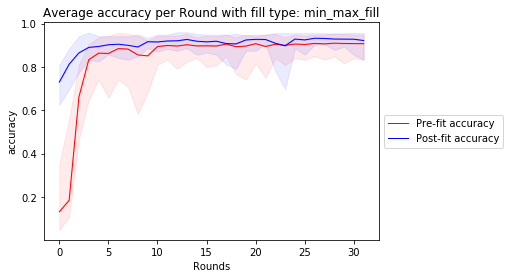

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.944444
3     1     0.925620
5     2     0.868217
7     3     0.941606
9     4     0.833333
11    5     0.928058
13    6     0.949275
15    7     0.871212
Averaged: 0.9077206924557686

Final accuracy for Post-fit data
   User  Final Value
0     0     0.952381
2     1     0.909091
4     2     0.930233
6     3     0.956204
8     4     0.933333
10    5     0.913669
12    6     0.949275
14    7     0.833333
Averaged: 0.9221899881958961



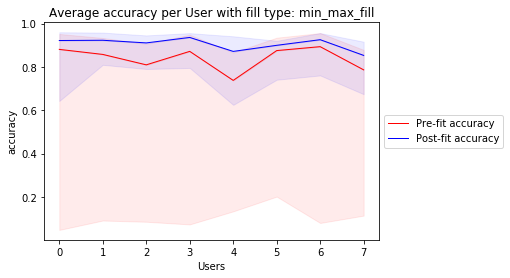

For p2p
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.906697
Standard Deviation    0.0445248
Minimum                     0.8
Maximum                0.944444
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.912499
Standard Deviation    0.0356486
Minimum                   0.825
Maximum                0.948905
Name: 63, dtype: object



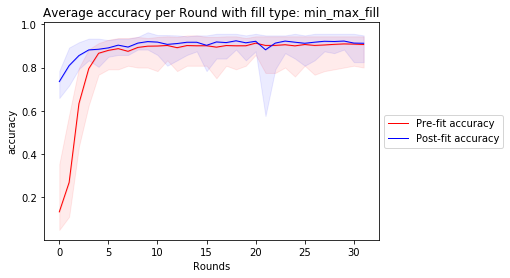

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.944444
3     1     0.917355
5     2     0.930233
7     3     0.941606
9     4     0.800000
11    5     0.920863
13    6     0.920290
15    7     0.878788
Averaged: 0.9066974148154259

Final accuracy for Post-fit data
   User  Final Value
0     0     0.944444
2     1     0.909091
4     2     0.914729
6     3     0.948905
8     4     0.825000
10    5     0.920863
12    6     0.920290
14    7     0.916667
Averaged: 0.9124986305832863



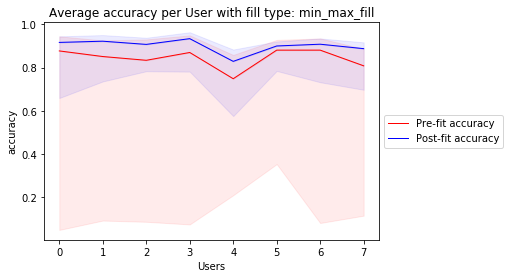

<Figure size 432x288 with 0 Axes>

In [8]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Std deviation")
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-stdround-{MAJORITY_SPLIT}.png",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-stduser-{MAJORITY_SPLIT}.png",
                                       final_values = final_values)
print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_std_dev_p2p, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-stdround_p2p-{MAJORITY_SPLIT}.png",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev_p2p, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-stduser_p2p-{MAJORITY_SPLIT}.png",
                                       final_values = final_values)


# print(users_std_dev[1].get_history_metrics())


In [9]:
averaging_methods = [Average.weighted_avg]

# return a dictionary of users with data
users_weighted_avg = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_weighted_avg, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.weighted_avg,
          averaging_post = True,
          averaging_metric = "accuracy")

# return a dictionary of users with data
users_weighted_avg_p2p = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_weighted_avg_p2p, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "personalised",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")

********************************  0   ********************************
0 [10.052072646125914, 0.04761905]
1 [8.326821461196774, 0.09090909]
2 [15.554481802060623, 0.08527132]
3 [11.466238613546329, 0.0729927]
4 [7.263989130655925, 0.20833333]
5 [5.534630871505189, 0.352518]
6 [12.8744749262713, 0.07971015]
7 [9.127996126810709, 0.11363637]
******************************** DONE ********************************
********************************  1   ********************************
0 [2.1058295832739935, 0.18253969]
1 [2.041679446362267, 0.1983471]
2 [2.0782319935717326, 0.14728682]
3 [2.0600293222135, 0.16788322]
4 [2.0341059446334837, 0.25833333]
5 [1.9677656751742465, 0.5179856]
6 [1.9833395377449368, 0.60144925]
7 [2.029828515919772, 0.22727273]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.691038243354313, 0.84126985]
1 [0.9054846024710285, 0.74380165]
2 [1.0467995114104693, 0.6124031

Weighted average
For central
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.894557
Standard Deviation    0.0604681
Minimum                    0.75
Maximum                0.949275
Name: 62, dtype: object


/home/kts1/proj/src/graphing.py:312: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(f'{save_as}.csv')


Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.920033
Standard Deviation    0.0217401
Minimum                0.883333
Maximum                0.944444
Name: 63, dtype: object



/home/kts1/proj/src/graphing.py:329: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(f'{save_as}.csv')


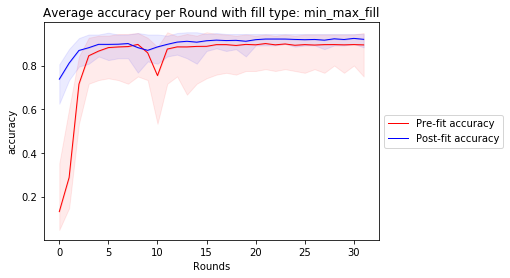

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.936508
3     1     0.925620
5     2     0.875969
7     3     0.927007
9     4     0.750000
11    5     0.920863
13    6     0.949275
15    7     0.871212
Averaged: 0.8945568650960922

Final accuracy for Post-fit data
   User  Final Value
0     0     0.944444
2     1     0.933884
4     2     0.906977
6     3     0.941606
8     4     0.883333
10    5     0.906475
12    6     0.942029
14    7     0.901515
Averaged: 0.9200329557061195



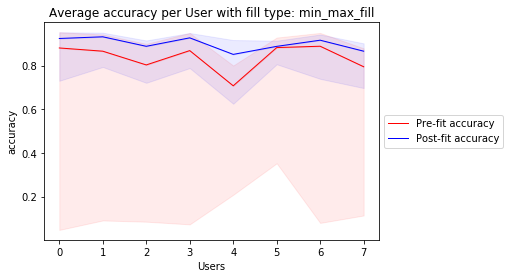

For p2p
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.903174
Standard Deviation    0.0439227
Minimum                   0.825
Maximum                0.952381
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.918259
Standard Deviation    0.0198634
Minimum                0.891667
Maximum                0.952381
Name: 63, dtype: object



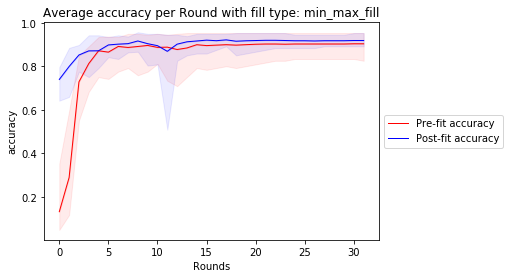

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.952381
3     1     0.925620
5     2     0.891473
7     3     0.941606
9     4     0.825000
11    5     0.920863
13    6     0.927536
15    7     0.840909
Averaged: 0.9031735211610794

Final accuracy for Post-fit data
   User  Final Value
0     0     0.952381
2     1     0.917355
4     2     0.914729
6     3     0.941606
8     4     0.891667
10    5     0.899281
12    6     0.927536
14    7     0.901515
Averaged: 0.9182586818933487



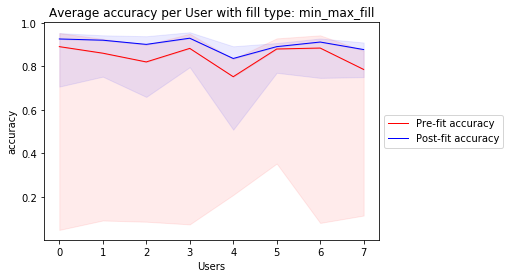

<Figure size 432x288 with 0 Axes>

In [10]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Weighted average")

print("For central")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-weightround-{MAJORITY_SPLIT}.png",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-weightuser-{MAJORITY_SPLIT}.png",
                                       final_values = final_values)

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg_p2p, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-weightround_p2p-{MAJORITY_SPLIT}.png",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg_p2p, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-weightuser_p2p-{MAJORITY_SPLIT}.png",
                                       final_values = final_values)


In [11]:
users_local_only = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_local_only, rounds = ROUNDS,
          epochs = EPOCHS,

          strat = "local_trainings_only",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")
        
#     print("Global user training and validation")

#     global_user.train(epochs = EPOCHS*ROUNDS,
#        verbose_fit = False,
#        verbose_evaluate = False,
#     )

********************************  0   ********************************
0 [10.052072646125914, 0.04761905]
1 [8.326821461196774, 0.09090909]
2 [15.554481802060623, 0.08527132]
3 [11.466238613546329, 0.0729927]
4 [7.263989130655925, 0.20833333]
5 [5.534630871505189, 0.352518]
6 [12.8744749262713, 0.07971015]
7 [9.127996126810709, 0.11363637]
******************************** DONE ********************************
********************************  1   ********************************
0 [0.9679093237907167, 0.6666667]
1 [0.6183755011105341, 0.7768595]
2 [0.8239706851715265, 0.68217057]
3 [0.6408278672364507, 0.7883212]
4 [1.0128681898117065, 0.65833336]
5 [0.6768898620879907, 0.74820143]
6 [0.6593500721281853, 0.76811594]
7 [1.1239947586348562, 0.68939394]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.49782213001024156, 0.82539684]
1 [0.35416737149569616, 0.892562]
2 [0.37080348623815435, 0.8

Local training only
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.860689
Standard Deviation    0.0353114
Minimum                0.787879
Maximum                0.899225
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.861681
Standard Deviation    0.0355316
Minimum                0.787879
Maximum                0.899225
Name: 63, dtype: object



/home/kts1/proj/src/graphing.py:312: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(f'{save_as}.csv')
/home/kts1/proj/src/graphing.py:329: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(f'{save_as}.csv')


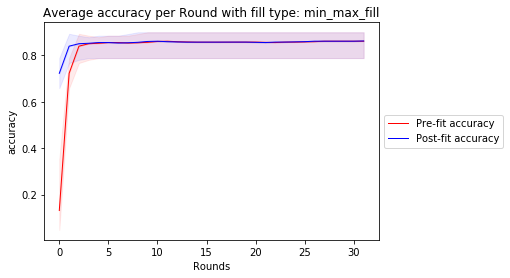

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.865079
3     1     0.892562
5     2     0.899225
7     3     0.854015
9     4     0.825000
11    5     0.877698
13    6     0.884058
15    7     0.787879
Averaged: 0.8606894165277481

Final accuracy for Post-fit data
   User  Final Value
0     0     0.873016
2     1     0.892562
4     2     0.899225
6     3     0.854015
8     4     0.825000
10    5     0.877698
12    6     0.884058
14    7     0.787879
Averaged: 0.8616814836859703



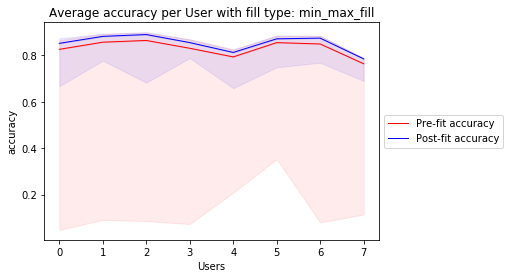

<Figure size 432x288 with 0 Axes>

In [12]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"


print("Local training only")


df_avg_round_stats_acc = avg_round_stats(users_local_only, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-localround-{MAJORITY_SPLIT}.png",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_local_only, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"{GRAPHING_METRIC}-localuser-{MAJORITY_SPLIT}.png",
                                       final_values = final_values)
# draw_graphs(users_all_p2p[2])

# print("Global user")
# draw_graphs(global_user)
# global_user.evaluate(verbose=False)

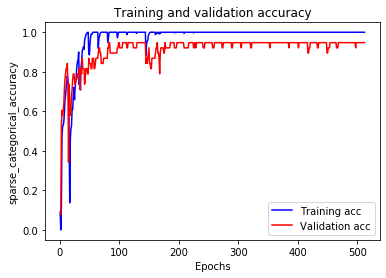

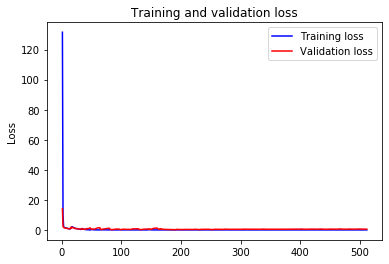

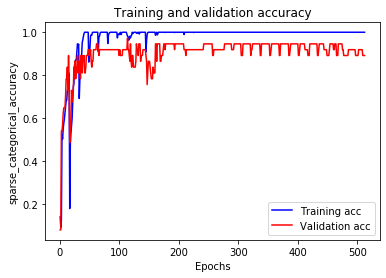

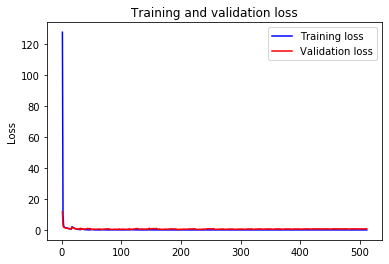

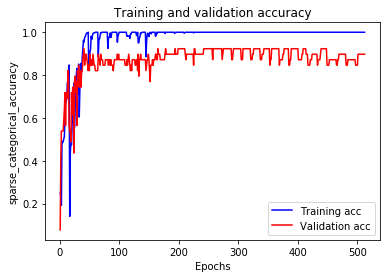

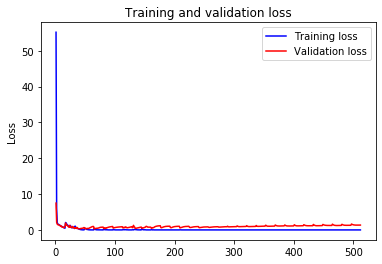

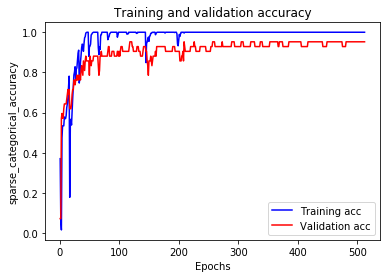

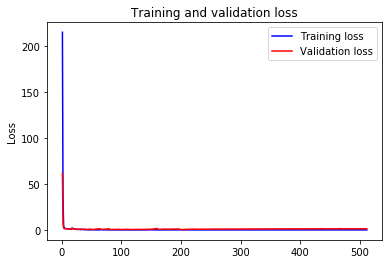

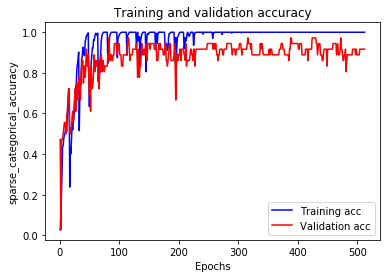

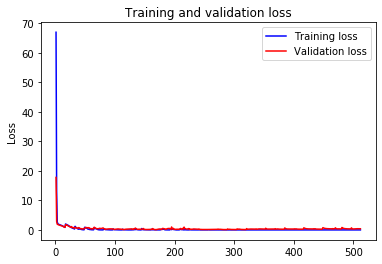

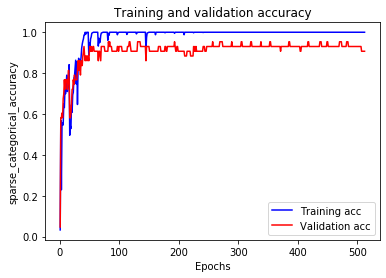

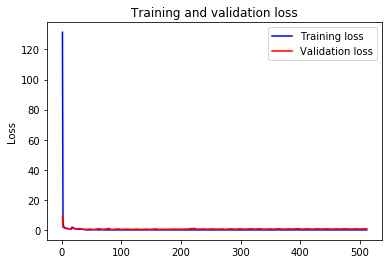

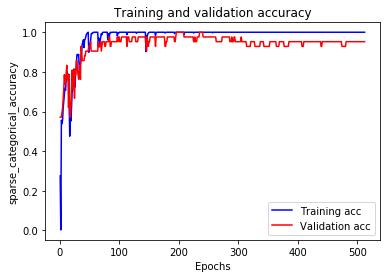

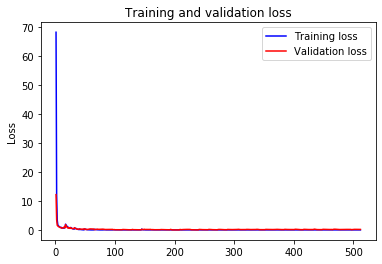

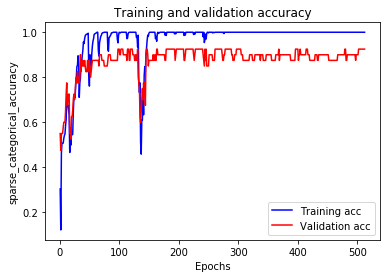

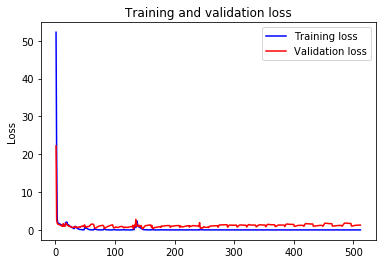

<Figure size 432x288 with 0 Axes>

In [13]:
for user in users_all.values():
    draw_graphs(user)

In [14]:
global_user = init_users_image(files,averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED, return_global_user=True)
print(global_user.get_train_data().dtype)
global_user.get_model().summary()
global_user.train(
    epochs = ROUNDS*EPOCHS,
    verbose_fit = True,
    verbose_evaluate = False
)


uint8
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_280 (Conv2D)          (None, 78, 78, 32)        896       
_________________________________________________________________
conv2d_281 (Conv2D)          (None, 76, 76, 64)        18496     
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_282 (Conv2D)          (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_283 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 8, 8, 128) 

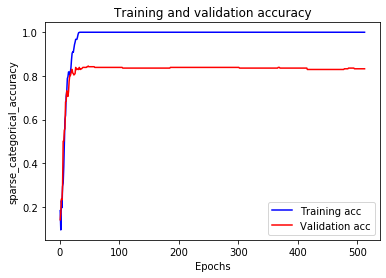

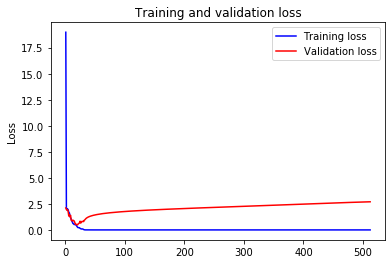

<Figure size 432x288 with 0 Axes>

In [15]:
draw_graphs(global_user)

In [16]:
print(global_user.evaluate(verbose=False))
g_weights = global_user.get_weights()

[1.5515172740089502, 0.88867563]


In [17]:
strats = [users_local_only, users_all, users_std_dev, users_std_dev_p2p, users_weighted_avg, users_weighted_avg_p2p]
strats_names = ["Local only", "All (traditional)", "Std dev Central", "Std dev P2P", "Weighted avg Central", "Weighted avg P2P"]
for i, strat in enumerate(strats):
    print(strats_names[i])
    for user in strat.values():
        global_user.set_weights(user.get_weights())
        print(f"{GRAPHING_METRIC}-{user.get_id()}: {global_user.evaluate(verbose=False)}")


Local only
accuracy-0: [2.0296308336294637, 0.77831095]
accuracy-1: [2.223028679269289, 0.7696737]
accuracy-2: [1.486263368414597, 0.80518234]
accuracy-3: [2.281138516037462, 0.7677543]
accuracy-4: [3.318069348179676, 0.7725528]
accuracy-5: [1.9289278386753976, 0.78023034]
accuracy-6: [2.15289593886963, 0.7754319]
accuracy-7: [3.636825596187943, 0.74088293]
All (traditional)
accuracy-0: [0.7924962552784954, 0.90211135]
accuracy-1: [0.8194614908895561, 0.8982726]
accuracy-2: [0.7950029210173809, 0.8982726]
accuracy-3: [0.7955423657176438, 0.89923227]
accuracy-4: [1.5926625338046814, 0.84740883]
accuracy-5: [0.8388667734462422, 0.8963532]
accuracy-6: [0.7620077279218644, 0.90019196]
accuracy-7: [1.3065455768095604, 0.8800384]
Std dev Central
accuracy-0: [0.6688585414851678, 0.90019196]
accuracy-1: [0.6955247330731539, 0.90115166]
accuracy-2: [0.6515049445182541, 0.9040307]
accuracy-3: [0.7920156668411357, 0.8953935]
accuracy-4: [1.2081903983157793, 0.85988486]
accuracy-5: [0.711606041712

In [18]:
# user = users_local_only[4]
for i, user in enumerate(users_all.values()):
    print(f"{GRAPHING_METRIC}-{CLASSES[i]:<10} -> {user.get_id()}: {np.unique(user.get_train_class(), return_counts=True)}")
    
print(f"{GRAPHING_METRIC}-{' ':<10} -> {global_user.get_id()}: {np.unique(global_user.get_train_class(), return_counts=True)}")
print(f"{GRAPHING_METRIC}-{' ':<10} -> {global_user.get_id()}: {np.unique(global_user.get_test_class(), return_counts=True)}")
print(f"{GRAPHING_METRIC}-{' ':<10} -> {global_user.get_id()}: {np.unique(global_user.get_val_class(), return_counts=True)}")

# print(np.equal(users_all[1].get_test_class(),users_weighted_avg[1].get_test_class()).all())

accuracy-motorbike  -> 0: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([316,  42,  49,  56,  41,  58,  57,  52]))
accuracy-airplane   -> 1: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 46, 291,  49,  56,  40,  58,  57,  52]))
accuracy-flower     -> 2: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 46,  42, 337,  56,  40,  58,  57,  51]))
accuracy-car        -> 3: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 45,  42,  48, 388,  40,  57,  56,  51]))
accuracy-dog        -> 4: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 45,  42,  48,  56, 281,  57,  56,  51]))
accuracy-fruit      -> 5: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 45,  42,  48,  56,  40, 400,  56,  51]))
accuracy-person     -> 6: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 45,  42,  48,  56,  40,  57, 395,  51]))
accuracy-cat        -> 7: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 45,  42,  48,  56,  40,  57,  56, 354]))
accuracy-           -> -1: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([633, 585, 675, 780, 562, 802, 790, 713]))
accuracy-         

[2.0537779199333452, 0.86549705]
,
strats = [users_local_only, users_all, users_std_dev, users_std_dev_p2p, users_weighted_avg, users_weighted_avg_p2p]
strats_names = ["Local only", "All (traditional)", "Std dev Central", "Std dev P2P", "Weighted avg Central", "Weighted avg P2P"]
for i, strat in enumerate(strats):
    print(strats_names[i])
    for user in strat.values():
        global_user.set_weights(user.get_weights())
        print(f"{GRAPHING_METRIC}-{user.get_id()}: {global_user.evaluate(verbose=False)}")
​
Local only
0: [9.757236800811798, 0.32748538]
1: [15.185893336466819, 0.23294348]
2: [15.314223988479107, 0.14814815]
3: [23.095221990004145, 0.22417153]
4: [36.134201971150375, 0.13060428]
5: [11.295852162452237, 0.2729045]
6: [18.789189883607637, 0.26608187]
7: [30.30204069713033, 0.13352826]
All (traditional)
0: [7.157162850363212, 0.43567252]
1: [9.494701476356068, 0.2582846]
2: [19.76187058475742, 0.15107213]
3: [13.823684065244434, 0.23781677]
4: [50.34867717850067, 0.21247563]
5: [2.990609238403038, 0.5477583]
6: [18.75717048592308, 0.26998052]
7: [23.408088814342825, 0.1325536]
Std dev Central
0: [1MAJORITY_SPLIT67827189224272, 0.40643275]
1: [12.490498023208177, 0.2602339]
2: [12.545851268133168, 0.20662768]
3: [14.380254255878338, 0.2563353]
4: [18.530827993582427, 0.1871345]
5: [1.9956236100471358, 0.48050684]
6: [14.49406118123928, 0.22124757]
7: [16.073231760513437, 0.15302144]
Std dev P2P
0: [5.2379543734803065, 0.47270957]
1: [9.79802004723844, 0.2777778]
2: [11.70396507230177, 0.21637426]
3: [13.573186689417724, 0.2202729]
4: [35.43924446076043, 0.14619882]
5: [4.088832839640076, 0.35477582]
6: [7.180660909160801, 0.32456142]
7: [23.349083881612355, 0.13547759]
Weighted avg Central
0: [13.989923677946392, 0.32651073]
1: [11.95330305066376, 0.2563353]
2: [12.189451936584002, 0.18615985]
3: [21.230742212639527, 0.17153996]
4: [20.873393699957443, 0.19103314]
5: [11.962356395075425, 0.27192983]
6: [11.42982605457695, 0.3011696]
7: [16.407368312165598, 0.17836258]
Weighted avg P2P
0: [7.491515232078389, 0.38109162]
1: [9.634372560317404, 0.33040935]
2: [14.897944022107787, 0.24366471]
3: [24.831768369812583, 0.24853802]
4: [28.249586317147287, 0.20467836]
5: [3.5148790881246943, 0.41812867]
6: [10.437260687118203, 0.27582845]
7: [23.649584703686685, 0.1374269]